In [1]:
import os
import sys
# import math
# import random

import gymnasium
sys.modules["gym"] = gymnasium

import gymnasium as gym
from gym.wrappers import RecordVideo

from base64 import b64encode
from IPython.display import HTML

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

print("CUDA доступна:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("pastel")

from tqdm import tqdm

CUDA доступна: True


In [2]:
os.makedirs("./video", exist_ok=True)

def render_mp4(videopath: str) -> str:

    """
    Функция для рендеринга видео в формате mp4.
    Args:
    videopath - Путь к файлу с видео.
    """
    
    mp4 = open(videopath, 'rb').read()
    base64_encoded_mp4 = b64encode(mp4).decode()
    return f'<video width=600 controls><source src="data:video/mp4; base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [3]:
env = gym.make("CarRacing-v3", render_mode="rgb_array") # , lap_complete_percent=0.95, domain_randomize=False, continuous=False
env = RecordVideo(env, video_folder="video", name_prefix=f"Racing", episode_trigger=lambda ep: ep % 200 == 0)
state, info = env.reset()
n_observations = len(state)
print(n_observations)

96


c:\Desk\Data\Otus\OtusHomework3\venv\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Desk\Data\Otus\OtusHomework3\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [4]:
class ActorNet(nn.Module):
    def __init__(self, num_actions=3):
        """
        Сеть Actor для CarRacing-v3.
        Принимает изображение размером (3, 96, 96) и выдает для каждого из 3-х действий
        параметр распределения: среднее (mean). Логарифм стандартного отклонения (log_std)
        может быть реализован как независимый обучаемый параметр.
        """
        super(ActorNet, self).__init__()
        # Свёрточные слои для извлечения признаков из изображения
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)   # Вход: (3,96,96) -> выход: (32, ? , ?)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # Расчёт выходного размера после свёрточных слоёв:
        # conv1: (96-8)//4 + 1 = 23, conv2: (23-4)//2 + 1 = 10, conv3: (10-3)//1 + 1 = 8.
        # Итоговый размер фич: 64 * 8 * 8 = 4096.
        self.fc = nn.Linear(4096, 512)
        # Выходной слой для вычисления средних значений для каждого действия (3 параметра)
        self.action_mean = nn.Linear(512, num_actions)
        # Логарифм стандартного отклонения – задается как обучаемый параметр независимо от входа.
        self.log_std = nn.Parameter(torch.zeros(num_actions))
        
    def forward(self, x):
        # x ожидается в формате [batch_size, 3, 96, 96]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Преобразуем в вектор
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)  # Используем reshape вместо view
        x = F.relu(self.fc(x))
        # mean = self.action_mean(x)
        mean = torch.tanh(self.action_mean(x))
        # Расширяем log_std до размера [batch_size, num_actions]
        log_std = self.log_std.expand_as(mean)
        return mean, log_std

class CriticNet(nn.Module):
    def __init__(self):
        """
        Сеть Critic для CarRacing-v3.
        Принимает изображение (3,96,96) и выдает скалярное значение ценности (value).
        """
        super(CriticNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc = nn.Linear(4096, 512)
        self.value = nn.Linear(512, 1)
        
    def forward(self, x):
        # x ожидается в формате [batch_size, 3, 96, 96]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)  # Используем reshape вместо view
        x = F.relu(self.fc(x))
        value = self.value(x)
        return value

actor_func = ActorNet().to(device)
value_func = CriticNet().to(device)

def pick_sample(s):
    with torch.no_grad():
        # Преобразуем входное состояние s из (96, 96, 3) в (3, 96, 96) и добавляем размер батча
        s_transposed = np.transpose(s, (2, 0, 1))
        s_batch = np.expand_dims(s_transposed, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float, device=device)
        
        # Получаем параметры распределения из сети Actor (предполагается, что actor_func возвращает (mean, log_std))
        mean, log_std = actor_func(s_batch)
        std = torch.exp(log_std)
        
        # Создаем нормальное распределение и сэмплируем действие
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        
        # Убираем размер батча и преобразуем в NumPy-массив
        action_np = action.squeeze(0).cpu().numpy()
        
        # Возвращаем NumPy-массив с типом float64
        return action_np.astype(np.float64)



In [5]:
%time
gamma = 0.99  # дисконтирование
reward_records = []  # массив наград

# Оптимизаторы
opt1 = torch.optim.AdamW(value_func.parameters(), lr=25e-4) 
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=25e-4)

# количество циклов обучения
num_episodes = 1500
# 
for i in tqdm(range(num_episodes)):
    # в начале эпизода обнуляем массивы и сбрасываем среду
    done = False
    states = [] 
    actions = []
    rewards = []
    s, _ = env.reset()
    s = s.astype(np.float32) / 255.0

    # пока не достигнем конечного состояния продолжаем выполнять действия
    while not done:
        # добавить состояние в список состояний
        states.append(s.tolist())
        # по текущей политике получить действие
        a = pick_sample(s)
        # выполнить шаг, получить награду (r), следующее состояние (s) и флаги конечного состояния (term, trunc)
        s, r, term, trunc, _ = env.step(a)
        # если конечное состояние - устанавливаем флаг окончания в True
        done = term or trunc
        # добавляем действие и награду в соответствующие массивы
        actions.append(a)
        rewards.append(r)
    # print(sum(rewards))        

    #
    # Если траектория закончилась (достигли финального состояния)
    #
    # формируем массив полной награды для каждого состояния
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Оптимизируем параметры сетей
    #

    # Оптимизируем value loss (Critic)
    # Обнуляем градиенты в оптимизаторе
    opt1.zero_grad()
    # преобразуем состояния и суммарные награды для каждого состояния в тензор
    states = torch.tensor(states, dtype=torch.float).to(device)
    states = states.permute(0, 3, 1, 2)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)

    # Вычисляем лосс
    values = value_func(states)
    values = values.squeeze(dim=1)
    vf_loss = F.mse_loss(
        values,
        cum_rewards,
        reduction="none")
    # считаем градиенты
    vf_loss.sum().backward()
    # делаем шаг оптимизатора
    opt1.step()

    # Оптимизируем policy loss (Actor)
    with torch.no_grad():
        values = value_func(states)

    # Обнуляем градиенты
    opt2.zero_grad()
    # преобразуем к тензорам
    # actions = torch.tensor(actions, dtype=torch.int64).to(device)
    actions_tensor = torch.tensor(actions, dtype=torch.float, device=device)
    # считаем advantage функцию
    advantages = cum_rewards - values

    # Получаем параметры распределения из сети Actor (распаковываем кортеж)
    mean, log_std = actor_func(states)
    std = torch.exp(log_std)

    # Создаем нормальное распределение по каждому измерению действия
    dist = torch.distributions.Normal(mean, std)
    # Вычисляем log probability для каждого действия.
    # Если действия многомерные, суммируем лог вероятности по последнему измерению.
    log_probs = dist.log_prob(actions_tensor).sum(dim=-1)
    # Определяем loss: умножаем отрицательные log probabilities на advantage
    # pi_loss = -log_probs * advantages

    beta = 0.01  # коэффициент энтропийного бонуса
    entropy = dist.entropy().sum(dim=-1)  # суммируем по действиям
    pi_loss = -log_probs * advantages - beta * entropy


    # Вычисляем градиенты и делаем шаг оптимизатора
    pi_loss.sum().backward()
    opt2.step()


    # # считаем лосс
    # logits, _ = actor_func(states)
    # log_probs = -F.cross_entropy(logits, actions, reduction="none")
    # pi_loss = -log_probs * advantages
    
    # # считаем градиент
    # pi_loss.sum().backward()
    # # делаем шаг оптимизатора
    # opt2.step()

    # Выводим итоговую награду в эпизоде (max 500)    
    reward_records.append(sum(rewards))

    # if i % 100 == 0:
    #     print("Run episode {} with average reward {}".format(i, np.mean(reward_records[-100:])), end="\r")

    # stop if mean reward for 100 episodes > 475.0
    # if np.average(reward_records[-100:]) > 475.0:
    #     break

print("\nDone")
env.close()

CPU times: total: 0 ns
Wall time: 0 ns


  0%|          | 0/1500 [00:00<?, ?it/s]C:\Users\deari\AppData\Local\Temp\ipykernel_13972\4060104640.py:77: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  actions_tensor = torch.tensor(actions, dtype=torch.float, device=device)
100%|██████████| 1500/1500 [5:39:31<00:00, 13.58s/it]  


Done


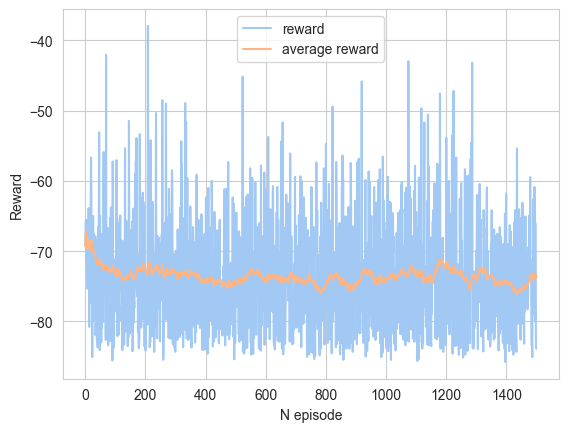

In [6]:
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Plot
plt.plot(reward_records, label='reward')
plt.plot(average_reward, label='average reward')
plt.xlabel('N episode')
plt.ylabel('Reward')
plt.legend()
plt.show()